# Video-based fight detection using deep learning 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import libraries

In [ ]:
!pip install sk-video

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 18.2 MB/s eta 0:00:00


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt 
import skvideo.io  
import os 
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import io
import imageio
import ipywidgets
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K


## Install Scikit-Video

In [ ]:
!pip install scikit-video

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 18.0 MB/s eta 0:00:00


## Add surveillance fight dataset from github

In [ ]:
!git clone https://github.com/seymanurakti/fight-detection-surv-dataset.git

Cloning into 'fight-detection-surv-dataset'...
remote: Enumerating objects: 340, done.
remote: Total 340 (delta 0), reused 0 (delta 0), pack-reused 340
Receiving objects: 100% (340/340), 84.35 MiB | 24.12 MiB/s, done.
Resolving deltas: 100% (11/11), done.


## Load, resize and trim the videos

In [ ]:
def frame_crop_center(video,cropf):
    f,_,_,_ = video.shape
    startf = f//2 - cropf//2
    return video[startf:startf+cropf, :, :, :]

fights=[]
nofights=[]

surv_fights=[]
surv_no_fights=[]

video_dims = []

####### Fight data/content/drive/MyDrive/archive
for filename in os.listdir('/content/drive/MyDrive/archive/Peliculas/fights'):
    f = os.path.join('/content/drive/MyDrive/archive/Peliculas/fights', filename)
    # checking if it is a file
    video = skvideo.io.vread(f)
    video_dims.append(video.shape)
    L=[]
    
    #resize video dimensions
    for i in range(video.shape[0]):
      frame = cv2.resize(video[i], (128,128), interpolation=cv2.INTER_CUBIC)
      L.append(frame)

    video = np.asarray(L)
    
    #center crop video to have consistent video frame number
    video = frame_crop_center(video, 42)
    
    fights.append(video)

for filename in os.listdir('/content/fight-detection-surv-dataset/fight'):
    f = os.path.join('/content/fight-detection-surv-dataset/fight', filename)
    # checking if it is a file
    video = skvideo.io.vread(f)
    video_dims.append(video.shape)
    
    L=[]
    for i in range(video.shape[0]):
      frame = cv2.resize(video[i], (128,128), interpolation=cv2.INTER_CUBIC)
      L.append(frame)

    video = np.asarray(L)
    video = frame_crop_center(video, 42)
    
    surv_fights.append(video)

####### Non Fight data
for filename in os.listdir('/content/drive/MyDrive/archive/Peliculas/noFights'):
    f = os.path.join('/content/drive/MyDrive/archive/Peliculas/noFights', filename)
    # checking if it is a file
    video = skvideo.io.vread(f)
    video_dims.append(video.shape)
    
    L=[]
    for i in range(video.shape[0]):
      frame = cv2.resize(video[i], (128,128), interpolation=cv2.INTER_CUBIC)
      L.append(frame)

    video = np.asarray(L)
    video = frame_crop_center(video, 42)

    nofights.append(video)

for filename in os.listdir('/content/fight-detection-surv-dataset/noFight'):
    f = os.path.join('/content/fight-detection-surv-dataset/noFight', filename)
    # checking if it is a file
    video = skvideo.io.vread(f) 
    video_dims.append(video.shape)

    L=[]
    for i in range(video.shape[0]):
      frame = cv2.resize(video[i], (128,128), interpolation=cv2.INTER_CUBIC)
      L.append(frame)

    video = np.asarray(L)
    video = frame_crop_center(video, 42)

    surv_no_fights.append(video)

## Video duration and dimension analysis 

The mean number of frames in the videos is 54 which corresponds to around 2 seconds. 
To make the video duration consistent without losing lots of data the videos are trimmed to have 42 frames in total with a center crop. 

Using a smaller frame number results in poorer performance. 

In [ ]:
data= pd.DataFrame(video_dims, columns=['frame_length', 'height', 'width', 'channels'])
data.describe()

,frame_length,height,width,channels
count,501.000000,501.000000,501.000000,501.0
mean,53.814371,486.483034,761.321357,3.0
std,13.348538,159.514107,298.154756,0.0
min,20.000000,216.000000,320.000000,3.0
25%,50.000000,360.000000,640.000000,3.0
50%,50.000000,480.000000,720.000000,3.0
75%,60.000000,576.000000,720.000000,3.0
max,142.000000,1080.000000,1920.000000,3.0


## Aggregate data and create labels 

In [ ]:
surv_fights = [video for video in surv_fights if video.shape[0] == 42]
surv_no_fights = [video for video in surv_no_fights if video.shape[0] == 42]

videos = fights + surv_fights + nofights + surv_no_fights
videos = np.asarray(videos)

labels = np.concatenate([np.ones(len(fights)+len(surv_fights)) , np.zeros(len(nofights)+len(surv_no_fights))])

del fights
del nofights
del surv_fights
del surv_no_fights

## Train, test, val split 

# *CNN-RNN model*

### Build Inception V3 feature extractor 

In [ ]:
IMG_SIZE = 128

def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

87910968/87910968 [==============================] - 1s 0us/step


### Create masks, process and prepare data

Takes around 10 ~ 20 minutes to execute

In [ ]:
MAX_SEQ_LENGTH = 42
NUM_FEATURES = 2048

def prepare_all_videos():
    num_samples = len(videos)
    
    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx in range(len(videos)):
        # Gather all its frames and add a batch dimension.
        if idx % 25 == 0:
            print(idx,'/',len(videos), ' videos prepared')
        frames = videos[idx][None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks)


processed_data = prepare_all_videos()

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 78ms/step
350 / 461  videos prepared
1/1 [==============================] - 0s 70ms/step
375 / 461  videos prepared
1/1 [==============================] - 0s 69ms/step
400 / 461  videos prepared
1/1 [==============================] - 0s 76ms/step
425 / 461  videos prepared
1/1 [==============================] - 0s 94ms/step
450 / 461  videos prepared
1/1 [==============================] - 0s 76ms/step


In [ ]:
processed_data[0].shape

(461, 42, 2048)

### Train, test split 

In [ ]:
X_train_features, X_test_features, y_train, y_test = train_test_split(processed_data[0], labels, test_size=0.2, random_state=2334)
X_train_masks, X_test_masks, y_train, y_test = train_test_split(processed_data[1], labels, test_size=0.2, random_state=2334)


print(X_train_features.shape)
print(X_test_features.shape)

(368, 42, 2048)
(93, 42, 2048)


### Build train and evaluate model 

In [ ]:
# Utility for our sequence model.
def get_sequence_model():
    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(2, activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy", recall_m, precision_m, f1_m]
    )
    return rnn_model


# Utility for running experiments.
def run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [X_train_features, X_train_masks],
        y_train,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy, recall, prec, f1 = seq_model.evaluate([X_test_features, X_test_masks], y_test)

    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test recall: {round(recall * 100, 2)}%")
    print(f"Test precision: {round(prec * 100, 2)}%")
    print(f"Test F1: {round(f1 * 100, 2)}%")
    cnn_rnn_scores = [accuracy, recall, prec, f1]


    return history, seq_model, cnn_rnn_scores


_, sequence_model, cnn_rnn_scores = run_experiment()

sequence_model.save('cnn_rnn_model')

3/3 [==============================] - 3s 29ms/step


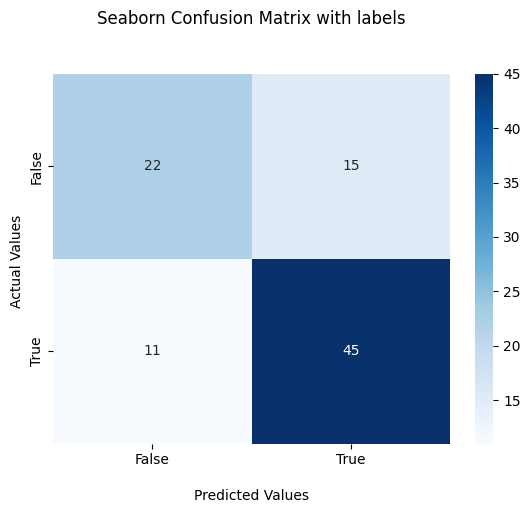

In [ ]:
y_preds = np.argmax(sequence_model.predict([X_test_features, X_test_masks]), axis=1)

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_preds)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()
ax.figure.savefig("cnn_rnn_cf.png") 
